In [4]:
from __future__ import division
%matplotlib inline
%pylab inline
import csv
import sys
import os
import traceback
import json
import pickle
import random
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import stats
from scipy.signal import argrelextrema
import itertools
import scipy.fftpack as fft
from scipy.stats import norm, skew, kurtosis
from scipy.signal import butter, lfilter, filtfilt
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from collections import defaultdict, Counter, OrderedDict
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval
from operator import itemgetter
from detect_peaks import detect_peaks
from gaussian_kde import gaussian_kde
import mean_shift as ms
import mean_shift_utils as ms_utils
import meta_features

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
acc_axes = ['x','y','z']
mat_dir = '../data/multi_split'
sym_dir = os.path.join(mat_dir)#, 'symbolization')
files = [f.split('__')[1] for f in getListOfFiles(sym_dir, ".mat")]
print ">> {} mat Files found!".format(len(files))

>> 87 mat Files found!


In [3]:
dataset = OrderedDict()
previous_files = None

for ind, current_file in enumerate(files):
    file_data = {}
    for axis in acc_axes:
        ## load correspoding data structure
        mat_content = sio.loadmat(os.path.join(sym_dir, axis+'__'+current_file))
        data = mat_content['exp']
        val = data[0,0]

        ## grab the data
        ts = [x[0] for x in val['sig_data']]
        splitpoints = val['split_cand'][0].tolist()
        weights =  val['weights'][0].tolist()

        # structuring individual axis data
        file_data[axis+'.ts'] = ts
        file_data[axis+'.splits'] = splitpoints[:-1]
        file_data[axis+'.weights'] = weights[:-1]
    dataset[current_file] = file_data
print '>> {} files loaded'.format(len(dataset.keys()))

>> 29 files loaded


In [ ]:
figsize(20,6)
file_number = 0
figsize(16,3)
markers = ['v', '^', '*']
for i,axis in enumerate(acc_axes):
    plt.plot(dataset[files[file_number]][axis+'.ts'], label= axis)
    y = np.random.rand(1,len(dataset[files[file_number]][axis+'.splits']))
    plt.scatter(dataset[files[file_number]][axis+'.splits'],y, marker=markers[i], label=axis+' split points')
plt.title('Data for ' + files[file_number])
plt.xlim(0,plt.xlim()[1])
plt.ylim(-5,5)
plt.legend()
plt.show()

## getting the separation points

In [ ]:
ma_mi_list = {}
cluster_centers = {}
tau = 1
for ind, current_file in enumerate(dataset.keys()):
    fig=figure(figsize=(15,8))
    ax1=fig.add_subplot(311)
    
    split_cand_list = []
    weigth_list = []
    data = dataset[current_file]
    for axis in acc_axes:
        split_cand_list += [(s,axis) for s in data[axis+'.splits']]
        weigth_list     += [(w,axis) for w in data[axis+'.weights']]

    weights = np.array([w[0] for w in weigth_list], np.float)
    samples = np.array([s[0] for s in split_cand_list])

    min, max = 0,len(data['x.ts'])
    x = np.linspace(min, max, max)

    clusters = []

    #Construct a KDE and plot it
    bws = [0.03]#0.01, 0.02, 0.03, 0.06, 0.1]
    ma = None
    mi = None
    for bw in bws:
        pdf = gaussian_kde(samples, bw_method=bw, weights=weights)
        y = pdf(x)
        ax1.plot(x, y, label='weighted kde, bw='+ str(bw))
        # mi = list of minimum indices in y.
        # ma = list of maximum indices in y.
        mi, ma = argrelextrema(y, np.less)[0], argrelextrema(y, np.greater)[0]
        #print "Minima:", x[mi]
        #print "Maxima:", x[ma]

        samples2 = []
        for s,w in zip(split_cand_list,weigth_list):
            samples2.append((s[0],w[0],s[1]))
        samples2 = np.array(samples2)

        for xc in x[mi]:
            ax1.axvline(x=xc, color='k', linestyle='-.')

        ## Get clusters by considering each one as a region between minimas. 
        # Count the itens for each cluster region. O(K), where K are regions defined by minimas.
        for m in range(len(mi)):
            if m == 0:
                clusters.append(samples2[samples < x[mi[m]]].tolist())
            else:
                clusters.append(samples2[(samples >= x[mi[m-1]]) * (samples <= x[mi[m]])].tolist())

        ax1.plot(x[ma], y[ma], 'g^',x[mi], y[mi], 'rv')

    ## Saving maxima e minima
    ma_mi_list[current_file] = {'mi': mi, 'ma': ma}
    
    energies = []
    total_energy = 0
    for ind,c in enumerate(clusters):
        accumulator = 0
        for elem in c:
            accumulator += float(elem[1])
        total_energy += accumulator
        energies.append((accumulator,ind))

    #energies = [(e/total_energy,ind) for inx,e in enumerate(energies)]

    #print 'Total energy: {}'.format(total_energy)
    #print 'Total energy after normalization: {}'.format(sum([e[0] for e in energies]))
    energies.sort(reverse=True, key=lambda tup: tup[0])

    #Plot the split candidates
    markers = ['o','x','^']
    colors = ['b', 'r','m']
    for i,axis in enumerate(acc_axes):
        ax1.scatter(data[axis+'.splits'], np.zeros_like(data[axis+'.splits']),
                    label='Split candidate for {}'.format(axis),
                    marker=markers[i], color='m')

    #Boiler plate
    plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
    ax1.set_title('Split point gaussian kernel density estimation for {}'.format(current_file))
    ax1.set_xlabel('Variable')
    ax1.set_ylabel('Density')
    plt.legend(loc='best', frameon=False)

    final_clusters = []
    accumulator = 0
    for e in energies:
        accumulator += e[0]
        if accumulator > tau*total_energy:
            break
        else:
            final_clusters.append(e[1])

    #print 'Total: {}, Accumulator: {}, Threshold: {}'.format(total_energy,accumulator,tau*total_energy)
    cluster_centers[current_file] = x[ma[final_clusters]]

    ax2 = fig.add_subplot(312, sharex=ax1)
    ax2.plot(x, y, label='weighted kde, bw='+ str(bw))
    for xc in x[ma[final_clusters]]:
            ax2.axvline(x=xc, color='k', linestyle='-.')
    ax2.set_ylim(-0.0003,ax2.get_ylim()[1])
    plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
    plt.legend(loc='best', frameon=False)

    ax3 = fig.add_subplot(313, sharex=ax1)
    for axis in acc_axes:
        ax3.plot(data[axis+'.ts'], label=axis)

    for xc in x[ma[final_clusters]]:
        ax3.axvline(x=xc, color='k', linestyle='-.')     

    plt.xticks(x[ma[final_clusters]],rotation = 90, fontsize=8)
    plt.legend(loc='best', frameon=False)
    plt.tight_layout()
    #plt.ylim(-0.0003,plt.ylim()[1])
    plt.xlim(min,max)
    plt.show()

## Getting the segments

In [ ]:
def get_segments(filename,maximas):
    data = dataset[filename]
    x_segments = []
    y_segments = []
    z_segments = []
    alignments = []
    
    min, max = 0,len(data['x.ts'])
    x = np.linspace(min, max, max)
    
    centers = [int(i) for i in sorted(cluster_centers[filename])]
    x_data = np.array(data['x.ts'])
    y_data = np.array(data['y.ts'])
    z_data = np.array(data['z.ts'])
    for i in range(len(centers)):
            if i == 0:
                x_segments.append(x_data[:int(centers[i])])
                y_segments.append(y_data[:int(centers[i])])   
                z_segments.append(z_data[:int(centers[i])])
                alignments.append(0)
            elif i == (len(centers)-1):
                x_segments.append(x_data[int(centers[i-1]):int(centers[i])].tolist())
                x_segments.append(x_data[int(centers[i]):].tolist())
                y_segments.append(y_data[int(centers[i-1]):int(centers[i])].tolist())
                y_segments.append(y_data[int(centers[i]):].tolist())
                z_segments.append(z_data[int(centers[i-1]):int(centers[i])].tolist())
                z_segments.append(z_data[int(centers[i]):].tolist())

                alignments.append(centers[i-1])
                alignments.append(centers[i])
            else:
                x_segments.append(x_data[int(centers[i-1]):int(centers[i])].tolist())
                y_segments.append(y_data[int(centers[i-1]):int(centers[i])].tolist())
                z_segments.append(z_data[int(centers[i-1]):int(centers[i])].tolist())
                alignments.append(centers[i-1])
    return x_segments, y_segments, z_segments, alignments

## Checking data segments equality with original time series.

In [ ]:
x_segments = []
y_segments = []
z_segments = []
alignments = []
file_map_list   = []

for f in dataset.keys():
    x_seg, y_seg, z_seg, aligns = get_segments(f,ma_mi_list[f]['ma'])
    ### testing equality
    try:
        assert list(itertools.chain.from_iterable(x_seg)) == dataset[f]['x.ts']
        assert list(itertools.chain.from_iterable(y_seg)) == dataset[f]['y.ts']
        assert list(itertools.chain.from_iterable(z_seg)) == dataset[f]['z.ts']
    except AssertionError:
        _, _, tb = sys.exc_info()
        traceback.print_tb(tb) # Fixed format
        tb_info = traceback.extract_tb(tb)
        filename, line, func, text = tb_info[-1]
        print('An error occurred on line {} in statement {}'.format(line, text))
        print('Equivalence test failed for file {}. ABORTING'.format(f))
        break
    
    for i in range(len(x_seg)):
        x_segments.append(x_seg[i])
        y_segments.append(y_seg[i])
        z_segments.append(z_seg[i])
        alignments.append(aligns[i])
        file_map_list.append('.'.join(f.split('.')[:-1]))
    
print 'ALL files PASSED on equivalence tests. This means the segmentation does not lose data!'

## Framming corpus

In [ ]:
df = {
      'x'    : x_segments,
      'y'    : y_segments,
      'z'    : z_segments,
      'align' : alignments,
      'file' : file_map_list
     }

frame = pd.DataFrame(df, index = [range(len(file_map_list))] , columns = ['x','y','z','align','file'])

## Exporting model to pickle.

In [ ]:
# open the file for writing
pkl_file_name = 'segments.pkl'
file_object = open(pkl_file_name,'wb')
pickle.dump(frame,file_object)
file_object.close()
print 'pickle DONE!'

## Plot by segment

In [ ]:
figure(figsize=(15,3))
filename = dataset.keys()[0]
for xc in cluster_centers[filename]:
    plt.axvline(x=xc, color='m', linestyle='-.')

x = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['x'].tolist()))
y = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['y'].tolist()))
z = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['z'].tolist()))
plt.plot(x,'-', label='x')
plt.plot(y, '-', label='y')
plt.plot(z, '-', label='z')
plt.title("Reconstructed file {}".format(filename))
plt.legend()
plt.xticks(cluster_centers[filename], rotation = 90)
#plt.ylim(-6,6)
plt.show()

____

## Bandwith selection

In [ ]:
ma_mi_list = {}
cluster_centers = {}
tau = 1#0.95
current_file = dataset.keys()[0]
fig=figure(figsize=(15,10))
ax1=fig.add_subplot(311)

split_cand_list = []
weigth_list = []
data = dataset[current_file]
for axis in acc_axes:
    split_cand_list += [(s,axis) for s in data[axis+'.splits']]
    weigth_list     += [(w,axis) for w in data[axis+'.weights']]

weights = np.array([w[0] for w in weigth_list], np.float)
samples = np.array([s[0] for s in split_cand_list])

min, max = 0,len(data['x.ts'])
x = np.linspace(min, max, max)

clusters = []

#Construct a KDE and plot it
bws = [0.03,0.01, 0.02, 0.03, 0.06]
for bw in bws:
    pdf = gaussian_kde(samples, bw_method=bw, weights=weights)
    y = pdf(x)
    ax1.plot(x, y, label='weighted kde, bw='+ str(bw))


#Plot the split candidates
markers = ['o','x','^']
colors = ['b', 'r','m']
for i,axis in enumerate(acc_axes):
    ax1.scatter(data[axis+'.splits'], np.zeros_like(data[axis+'.splits']),
                label='Split candidate for {}'.format(axis),
                marker=markers[i], color='m')

#Boiler plate
plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
ax1.set_title('Split point gaussian kernel density estimation for {}'.format(current_file))
ax1.set_xlabel('Cutting point')
ax1.set_ylabel('Density')
plt.legend(loc='best', frameon=False)

ax3 = fig.add_subplot(312, sharex=ax1)
for axis in acc_axes:
    ax3.plot(data[axis+'.ts'], label=axis)   

plt.legend(loc='best', frameon=False)
plt.tight_layout()
ax1.set_xlabel('Acceleration')
ax1.set_ylabel('Cutting point')
plt.xlim(min,max)
plt.show()

# Loading pickle

In [5]:
resframe = []
with open("../pickle/annotation.pkl",'r') as f:
    resframe = pickle.load(f)
resframe.shape

(571, 6)

In [6]:
x_df = None
y_df = None
z_df = None
sup_resframe = resframe[resframe['tag'] !=""]
print 'Supervised dataset dim: {}'.format(sup_resframe.shape)
print 'Columns: {}'.format(sup_resframe.columns.tolist())
for df in sup_resframe.itertuples():
    x = pd.DataFrame({df[0]:df[1]})
    y = pd.DataFrame({df[0]:df[2]})
    z = pd.DataFrame({df[0]:df[3]})
    if df[0] == 0:
        x_df = x
        y_df = y
        z_df = z
    else:
        x_df = pd.concat([x_df,x], ignore_index=True, axis=1)
        y_df = pd.concat([y_df,y], ignore_index=True, axis=1)
        z_df = pd.concat([z_df,z], ignore_index=True, axis=1)
#x_df = pd.concat([x_df,sup_resframe.loc[:,'file':'tag']], ignore_index=True, axis=1)
#x_df.columns = x_df.columns[:-2].tolist() + ['file','tag']
#y_df = pd.concat([y_df,sup_resframe.loc[:,'file':'tag']], ignore_index=True, axis=1)
#y_df.columns = y_df.columns[:-2].tolist() + ['file','tag']
#z_df = pd.concat([z_df,sup_resframe.loc[:,'file':'tag']], ignore_index=True, axis=1)
#z_df.columns = z_df.columns[:-2].tolist() + ['file','tag']
print x_df.shape #all x's + file, tag
print y_df.shape #all y's + file, tag
print z_df.shape #all z's + file, tag


Supervised dataset dim: (286, 6)
Columns: ['x', 'y', 'z', 'align', 'file', 'tag']
(455, 286)
(455, 286)
(455, 286)


In [7]:
supervised = resframe[resframe['tag'] !=""]
print 'Supervised: {}'.format(supervised.shape)

Supervised: (286, 6)


In [8]:
unsupervised = resframe[resframe['tag'] ==""]
print 'Unsupervised: {}'.format(unsupervised.shape)

Unsupervised: (285, 6)


## Visualizing the distribution

#### loading metafeatures dispatcher

In [ ]:
reload(meta_features)

In [9]:
function_dispatcher = {
    "mean"     : meta_features.mean,
    "std"      : meta_features.std,
    "max"      : meta_features.max_value,
    "min"      : meta_features.min_value,
    "mad"      : meta_features.mad,
    "sma"      : meta_features.sma,
    "iqr"      : meta_features.iqr,
    "energy"   : meta_features.energy,
    "fft_energy"   : meta_features.fft_energy,
    "maxInds"  : meta_features.maxInds,
    "meanFreq" : meta_features.meanFreq,
    "skewness" : meta_features.skewness,
    "kurtosis" : meta_features.kurtos,
    "freq_skewness" : meta_features.freq_skewness,
    "freq_kurtosis" : meta_features.freq_kurtos,
    "num_peaks"     : meta_features.num_peaks,
    "moving_rmsV1"  : meta_features.moving_rmsV1,
    "rms"           : meta_features.rms,
    "max_min"       : meta_features.max_min,
    "pse"           : meta_features.pse
}

In [10]:
def get_metafeat_vector(segment, sensor_name, mf=["mean","std","max","min","mad","sma",
                                        "iqr","energy","maxInds","meanFreq","skewness","kurtosis"]):
    """
        Compute metafeatures from segment data.
    
        segment : the time series segment
        mf      : list of metafeatures functions to be computed on the segment data.
    """
    
    meta_vector = OrderedDict()

    for f in mf:
        try:
            func = function_dispatcher[f]          # retrieve function
            meta_vector[sensor_name+'_'+f] = func(segment)    # compute function on segment.
        except KeyError:
            raise ValueError('Invalid function: {}'.format(f))

    return meta_vector

In [121]:
segment_len = 64   # WINDOWS SIZE
slide_len = 32      # WINDOWS OVERLAP

### windowing function
def win_function(data):
    window_rads = np.linspace(0, np.pi, len(data))
    window = np.sin(window_rads)**2
    return data * window

#### Loading the corresponding data

In [128]:
##### LOADING THE DATA ################
topics = ["{u'High_level': u'Blocking-Dodging'}",    #30
          "{u'High_level': u'Inactive'}",            #7
          "{u'High_level': u'Locally-Moving'}",      #78
          "{u'High_level': u'Running'}",             #73
          "{u'High_level': u'Sprinting'}",           #27
          "{u'High_level': u'Stop-Running'}",        #36
          "{u'High_level': u'Walking'}"]             #35

#topics = [topics[4]]

data = None

for topic in topics:
    topic_data_x = resframe[resframe['tag']== topic]['x'].tolist()
    topic_data_y = resframe[resframe['tag']== topic]['y'].tolist()
    topic_data_z = resframe[resframe['tag']== topic]['z'].tolist()
    
    x_sig_segments = []
    y_sig_segments = []
    z_sig_segments = []
    
    for i in range(len(topic_data_x)):     
        for start_pos in range(0, len(topic_data_x[i]), slide_len):
            end_pos = start_pos + segment_len
            # make a copy so changes to 'segments' doesn't modify the original ekg_data
            x_segment = np.copy(topic_data_x[i][start_pos:end_pos])
            y_segment = np.copy(topic_data_y[i][start_pos:end_pos])
            z_segment = np.copy(topic_data_z[i][start_pos:end_pos])
            
            # if we're at the end and we've got a truncated segment, drop it
            if len(x_segment) != segment_len:
                continue

            ##apply windowing function
            x_sig_segments.append(win_function(x_segment))
            y_sig_segments.append(win_function(y_segment))
            z_sig_segments.append(win_function(z_segment))

    ##### COMPUTING METAFEATURES ###########
    ## metafeatures list to be computed
    to_compute = ["mean","std","max","min","fft_energy","pse","mad","iqr","rms","maxInds","skewness","kurtosis","freq_skewness","freq_kurtosis"]
    #to_compute = ["mean","std","mad","sma","iqr","skewness","kurtosis","maxInds","rms","num_peaks"]
    #to_compute = ["fft_energy", "pse", "max_min","rms","num_peaks"]

    print 'Number of segments: {}'.format(len(x_sig_segments))
    assert len(x_sig_segments) == len(y_sig_segments) == len(z_sig_segments)
    for s in range(len(z_sig_segments)):
        x_meta_fts = get_metafeat_vector(x_sig_segments[s],'x',mf=to_compute).values()
        y_meta_fts = get_metafeat_vector(y_sig_segments[s],'y',mf=to_compute).values()
        z_meta_fts = get_metafeat_vector(z_sig_segments[s],'z',mf=to_compute).values()
        
        xy_corr     = meta_features.correlation(x_sig_segments[s], y_sig_segments[s])
        xz_corr     = meta_features.correlation(x_sig_segments[s], z_sig_segments[s])
        yz_corr     = meta_features.correlation(y_sig_segments[s], z_sig_segments[s])
        
        X = pd.DataFrame(np.array([x_meta_fts]), columns=['x_'+tc for tc in to_compute])
        Y = pd.DataFrame(np.array([y_meta_fts]), columns=['y_'+tc for tc in to_compute])
        Z = pd.DataFrame(np.array([z_meta_fts]), columns=['z_'+tc for tc in to_compute])
        corr = pd.DataFrame(np.array([[xy_corr,xz_corr,yz_corr]]), columns = ['xy_corr','xz_corr','yz_corr,'])
        top = pd.DataFrame([[topic]], columns = ['target'])
        if data is None:
            data = pd.concat([X, Y, Z, corr, top], axis=1, join_axes=[X.index])
        else:
            result = pd.concat([X, Y, Z, corr, top], axis=1, join_axes=[X.index])
            data = pd.concat([data,result])

Number of segments: 91
Number of segments: 21
Number of segments: 162
Number of segments: 171
Number of segments: 40
Number of segments: 53
Number of segments: 53


In [129]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20160101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [130]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([data[data.target==t].ix[:, data.columns != 'target']
               for t in topics])
y = np.hstack([data[data.target==t]['target']
               for t in topics])

In [152]:
#data_proj = TSNE(random_state=RS).fit_transform(X)
data_proj = TSNE(n_iter=10000,perplexity=50, learning_rate=500).fit_transform(X)

In [153]:
topic_colors = {"{u'High_level': u'Blocking-Dodging'}": 0,    #30
          "{u'High_level': u'Inactive'}": 1,            #7
          "{u'High_level': u'Locally-Moving'}": 2,      #78
          "{u'High_level': u'Running'}": 3,             #73
          "{u'High_level': u'Sprinting'}": 4,           #27
          "{u'High_level': u'Stop-Running'}": 5,        #36
          "{u'High_level': u'Walking'}": 6}

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 8))

    all_colors = np.array([topic_colors[c] for c in colors])
    
    assert len(all_colors) == len(colors) == len(x)

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[all_colors.astype(np.int)], cmap=plt.cm.get_cmap("jet", 8))
    #plt.colorbar(ticks=range(8))
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    return f, ax, sc

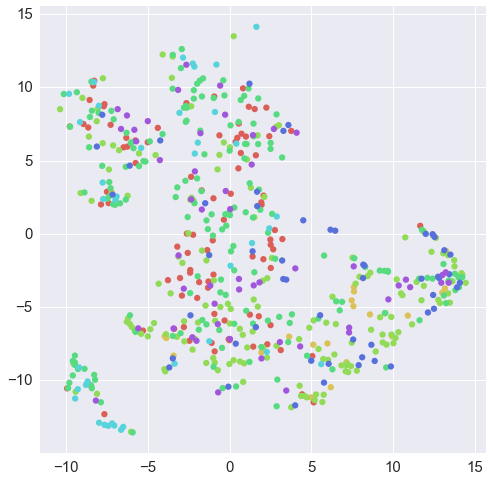

In [154]:
scatter(data_proj, y)
#plt.savefig(title+'.png')
plt.show()